# Задача о многоруком бандите

Продемонстрируем работу различных подходов, решающих задачу о многоруком бандите. В частности, рассмотрим работу **𝜺-жадных стратегий**, стратегий на основе **ВДГ-действий (UBC-действий)** и стратегий на основе **выборки Томпсона**. 

Симуляции будем проводить на примере бандита с 10-ю рычагами. Рычаги будем нумеровать индексами от 0 до 9. Для каждого временного отсчёта агент совершает действие, выбирая некоторый рычаг и дергая за него. Действия удобно также обозначать индексами от 0 до 9 в соответствии с выбраным рычагом. После выбора рычага агент получает вознаграждение. 

Технически, вознаграждения будем формировать следующим образом:  
1. Рычагу с индексом $k$ сопоставим случайную величину $\xi_k$, распределённую нормально с дисперсией 1 и с некоторым математическим ожиданием $\mu_k$. 
2. Выбор рычага с индексом $k$ выдаёт вознаграждение, которое является реализацией случайной величины $\xi_k$.

Задача агента заключается в максимизации суммарного вознаграждения (или дохода) за длительный период взаимодействия с бандитом (например в течении 1000 временных шагов).

### Оценка ценности действий

Сначала рассмотрим подход на основе вычисления оценок ценности действий. В нашем случае истинные оценки ценности действий - это значения математических ожиданий $\mu_k$. Простейший способ формирования оценки ценности рычага с индексом $k$ заключается в усреднении всех вознаграждений, полученных за выбор этого рычага. Эффективным образом эту оценку можно вычислять с помощью инкрементной реализации вычисления выборочного среднего. 

Зафиксируем рычаг $k$. Пусть $r_n$ обозначает вознаграждение, которое получено после $n$-го по счёту выбора этого рычага. Тогда оценка ценности этого рычага вычисляется по формуле

$Q_{n} = Q_{n-1} + \frac 1n (r_n - Q_{n-1}),$

где $Q_{n-1}$ - это оценка ценности этого рычага после его выбора $n-1$ раз. При вычислении оценок по методу выборочного среднего считаем, что $Q_0 = 0$.

Реализуем правило для обновления оценок ценностей рычагов. Для этого потребуется два массива, имеющих длину равную количеству рычагов:

1. массив `Q` для хранения текущих оценок ценностей рычагов
2. массив `N` для хранения количества выборов рычагов к текущему моменту.

Эти массивы инициализируем нулями. Кроме того, для генерации вознаграждения потребуется массив, хранящий истинные ценности действий `Q_true`, то есть $\mu_k$. Для начала зададим эти значения вручную.

Обновлять оценки будем на протяжении 1000 эпизодов. Выбор действия будем осуществлять случайным образом. Убедимся, что оценки действительно будут близки к истинным ценностям.

In [1]:
import numpy as np

Q_true = [1.0, 0.5, 0.2, 0.5, 0.6, 0.1, -0.5, 0.0, -0.7, -1.0]
num_arms = len(Q_true)
Q = np.zeros(num_arms)
N = np.zeros(num_arms)
num_steps = 10000


for i in range(0, num_steps):
    # равновероятный выбор действия 
    action = np.random.choice(num_arms)
    # получение вознаграждения, как реализации нормально распределённой случайной величины
    reward = np.random.randn() + Q_true[action]
    N[action] += 1
    Q[action] = Q[action] + (reward - Q[action])/N[action]
    

print("Оценки ценности рычагов:")
print(np.round(Q,2))
print("Число выборов рычагов:")
print(N)

Оценки ценности рычагов:
[ 1.08  0.5   0.22  0.54  0.61  0.09 -0.55  0.02 -0.66 -0.99]
Число выборов рычагов:
[1011.  976.  975. 1079. 1005.  952.  971. 1046. 1010.  975.]


### Сравнение eps-жадных стратегий

Сравним работу двух стратегий: 𝜺-жадной и жадной на примере десятирукого бандита. 

Технически, 𝜺-жадная стратегия реализуется следующим образом:

1. генерируется случайное число между нулём и единицей, оно сравнивается с параметром 𝜺;
2. если значение оказывается меньше 𝜺, то проводится исследование, то есть выбирается один рычаг из десяти равновероятно;
3. если же значение оказывается больше 𝜺, то выбираем рычаг с максимальной оценкой (если таких несколько, то все равно какой выбирать). 

Процесс работы агента и генерация вознаграждений зависит от ряда случайных параметров. Чтобы получить объективное представление о работе стратегий **необходимо много эпизодов взаимодействия агента с бандитом.**


В каждом эпизоде инициализируется массив истинных ценностей `Q_true` путём генерации 10 чисел нормально распределённых со средним 0 и стандартным отклонением 1. Далее агент выбирает рычаги в течении 1000 временных шагов. Для каждого эпизода
будем формировать два массива:
1. массив полученных вознаграждений в течении 1000 шагов;
2. бинарный массив длины 1000, где единицами будем отмечать выбор лучшего рычага (то есть с максимальной истинной ценностью). 

Далее, усредним полученные массивы по 2000 эпизодам. Тем самым, получим информацию о среднем вознаграждении и о среднем проценте выбора оптимальных действий за каждый временной шаг, что позволит более объективно сравенить стратегии.

Указанные выше шаги реализованы в методе bandit_simulation().

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def bandit_simulation(num_arms = 10, num_steps = 1000, num_episodes = 2000, epsilon = 0.01):    
    # создаём массив вознаграждений и массив с метками о выборе лучшего действия
    rewards = np.zeros((num_episodes, num_steps)) 
    best_action_counts = np.zeros((num_episodes, num_steps)) #
    
    for episode in tqdm(range(num_episodes)):
        # инициализация для запуска эпизода
        Q_true = np.random.randn(num_arms) 
        best_action = np.argmax(Q_true)       
        Q = np.zeros(num_arms)
        N = np.zeros(num_arms)
        # шаги эпизода
        for step in range(num_steps):
            # eps-жадный выбор действия
            if np.random.rand() < epsilon:
                action = np.random.choice(num_arms)
            else:
                action = np.argmax(Q)
                
            if action == best_action: 
                best_action_counts[episode, step] += 1

            # получение вознаграждения и обновление оценок
            reward = np.random.randn() + Q_true[action]
            N[action] += 1
            Q[action] = Q[action] + (reward - Q[action])/N[action]
            rewards[episode, step] = reward
    # усреднение
    avg_rewards = np.mean(rewards, axis = 0)
    avg_optimal = np.mean(best_action_counts, axis = 0)*100
        
    return avg_rewards, avg_optimal

Запустим симуляцию для 3-х значений eps и выведем результаты симуляции на графиках

In [3]:
epsilons = [0, 0.01, 0.1, 0.25]
all_rewards = []
all_optimal = []

for i, eps in enumerate(epsilons):
    avg_rewards, avg_optimal = bandit_simulation(epsilon=eps)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 123.00it/s]


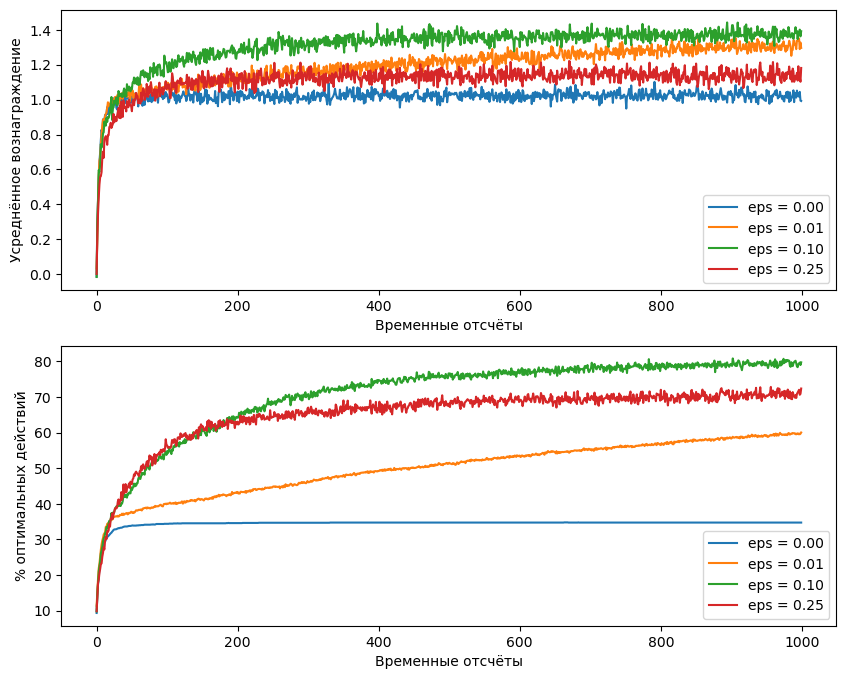

In [4]:
plt.figure(figsize=(10,8))     
plt.subplot(2, 1, 1)
for eps, rews in zip(epsilons, all_rewards):
    plt.plot(rews, label='eps = %.02f' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
for eps, opts in zip(epsilons, all_optimal):
    plt.plot(opts, label='eps = %.02f' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Как ясно из симуляции, чистая жадная стратегия уступает $\varepsilon$-жадным стратегиям, поскольку при отсутствии хороших оценок жадная стратегия не всегда позволяет выявить оптимальное действие.

$\varepsilon$-жадные стратегии для различных $\varepsilon$ также показывают несколько различные результаты. 
Стратегия со сравнительно большим $\varepsilon$ быстрее находит оптимальное действие, однако, оно выбирается с вероятностью $1-\varepsilon$. Но на длительной дистанции стратегии со сравнительно малым $\varepsilon$ обгонят по получаемым вознаграждениям стратегии со сравнительно большим $\varepsilon$, поскольку они чаще выбирают оптимальное действие.

 ### Стратегии с оптимистическим стартом
 
Добавим в симуляцию возможность стартовать с завышенных начальных оценок ценностей и рассмотрим работу $\varepsilon$-жадной и жадной стратегий с оптимистическими стартами и без них.

Для этого внесём простую модификацию в код для симуляции `bandit_simulation()`.

In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def bandit_simulation(num_arms = 10, num_steps = 1000, num_episodes = 2000, epsilon = 0.01, initial=0.0):    
    # массив вознаграждений и массив с метками о выборе лучшего действия
    rewards = np.zeros((num_episodes, num_steps)) 
    best_action_counts = np.zeros((num_episodes, num_steps)) #
    
    for episode in tqdm(range(num_episodes)):
        # инициализация для запуска эпизода
        Q_true = np.random.randn(num_arms) 
        best_action = np.argmax(Q_true)
        # NEW: инициализация с оптимистичным стартом
        Q = np.zeros(num_arms) + initial
        N = np.zeros(num_arms)
        # шаги эпизода
        for step in range(num_steps):
            # eps-жадный выбор действия
            if np.random.rand() < epsilon:
                action = np.random.choice(num_arms)
            else:
                action = np.argmax(Q)
                
            if action == best_action: 
                best_action_counts[episode, step] += 1

            # получение вознаграждения и обновление оценок
            reward = np.random.randn() + Q_true[action]
            N[action] += 1
            Q[action] = Q[action] + (reward - Q[action])/N[action]
            rewards[episode, step] = reward
    # усреднение
    avg_rewards = np.mean(rewards, axis = 0)
    avg_optimal = np.mean(best_action_counts, axis = 0)*100
        
    return avg_rewards, avg_optimal

Прведём симуляцию для следующих стратегий:

1. $\varepsilon$-жадная стратегия с $\varepsilon=0.1$,
2. жадная стратегия,
3. $\varepsilon$-жадная стратегия с $\varepsilon=0.1$ и оптимистическим стартом,
4. жадная стратегия и оптимистический старт.

In [6]:
epsilons = [0, 0.1]
all_rewards = []
all_optimal = []

for i, eps in enumerate(epsilons):
    avg_rewards, avg_optimal = bandit_simulation(num_steps = 2000, epsilon=eps)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)
    avg_rewards, avg_optimal = bandit_simulation(num_steps = 2000, epsilon=eps, initial = 5.0)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)   

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 81.31it/s]


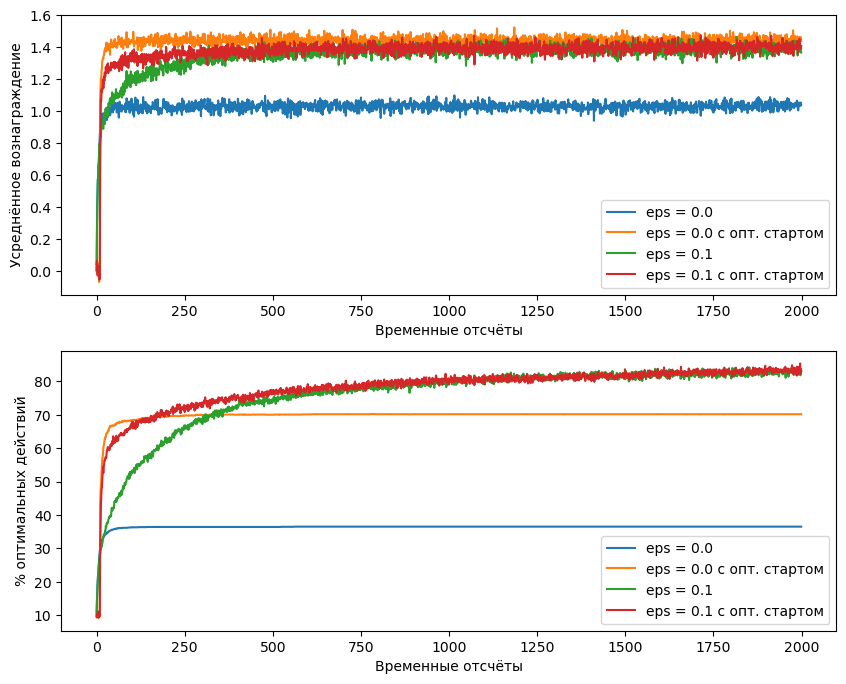

In [7]:
plt.figure(figsize=(10,8))     
plt.subplot(2, 1, 1)
for i, eps in enumerate(epsilons):
    plt.plot(all_rewards[2*i], label='eps = %.01f' % (eps))
    plt.plot(all_rewards[2*i+1], label='eps = %.01f с опт. стартом' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
for i, eps in enumerate(epsilons):
    plt.plot(all_optimal[2*i], label='eps = %.01f' % (eps))
    plt.plot(all_optimal[2*i+1], label='eps = %.01f с опт. стартом' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Для жадной стратегии наличие оптимистичного старта позволяет существенно увеличить среднее вознаграждение и процент выбора оптимальных действий. Но тем не менее не всегда жадная стратегия выявляет оптимальное действие.

Для $\varepsilon$-жадной стратегии наличие оптимтичного старта позволяет лишь быстрее выявить хорошее действие, но далее оптимистичный старт не влияет на среднее вознаграждение и процент выбора оптимальных действий

Можно также отметить, что при $\varepsilon=0.1$ среднее вознаграждение получается ниже, чем при жадной стратегии с оптимистичным стартом, хотя процент выбора оптимального действия выше. Это связано с тем, что всё-таки в 10% случаев выбирается случайное действие и это снижает среднее вознаграждение. Если снизить $\varepsilon$, например, до $0.01$, то среднее вознаграждение для $\varepsilon$-жадной стратегии будет выше, чем у жадной стратегии.

In [8]:
epsilons = [0, 0.01]
all_rewards = []
all_optimal = []

for i, eps in enumerate(epsilons):
    avg_rewards, avg_optimal = bandit_simulation(num_steps = 2000, epsilon=eps, initial = 5.0)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)   

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.61it/s]


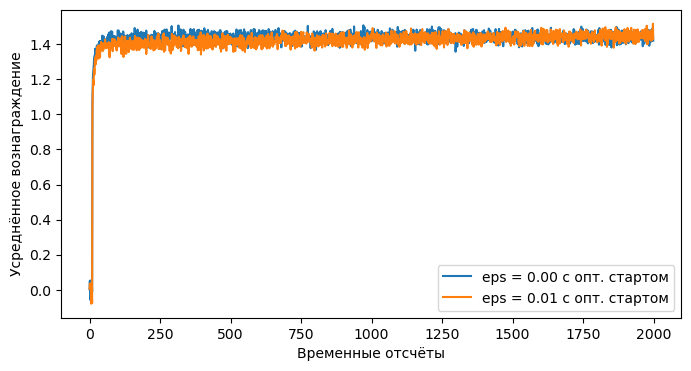

In [9]:
plt.figure(figsize=(8,4))     
for i, eps in enumerate(epsilons):
    plt.plot(all_rewards[i], label='eps = %.02f с опт. стартом' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

Выведем также график процента выбора оптимальных действий для 50 начальных временных шагов.

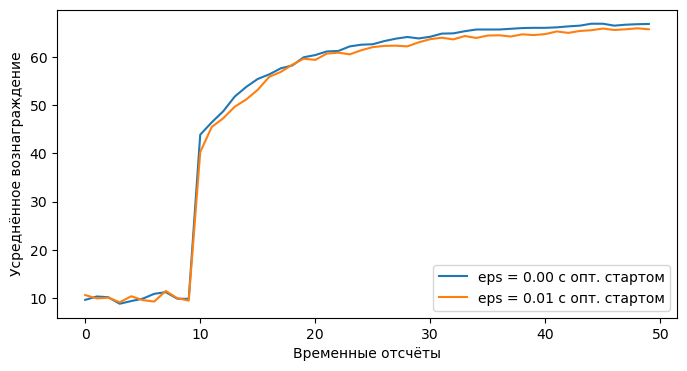

In [10]:
plt.figure(figsize=(8,4))     
for i, eps in enumerate(epsilons):
    plt.plot(all_optimal[i][0:50], label='eps = %.02f с опт. стартом' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

На этом графике видно, что процент выбора оптимальных действий резко подрастает на 10 отсчёте. Это вполне ожидаемо, так как после того как опробованы все 10 рычагов, самая большая оценка ценности чаще всего будет у рычага с самым большим истинным вознаграждением.

### Сравнение стратегий в нестационарном случае

Нестационарный случай значит, что с течением времени изменяются истинные вознаграждения.
Продемонстрируем, что постоянный размер шага обучения $\alpha$ лучше подходит для этого случая, чем вычисление оценок по методу выборочного среднего (то есть когда $\alpha = \frac 1n$, где $n$ число выборов действия).

Для этого изменим код симуляции, чтобы добавить возможности:
1. установить постоянный размер шага обучения и обновлять оценку в соответствии с этим шагом;
2. изменять истинные ценности на малую по модулю случайную величину каждый временной шаг.

In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def bandit_simulation(num_arms = 10, num_steps = 1000, num_episodes = 2000, epsilon = 0.01, 
                      initial=0.0, alpha = None, Q_changed = False):    
    # массив вознаграждений и массив с метками о выборе лучшего действия
    rewards = np.zeros((num_episodes, num_steps)) 
    best_action_counts = np.zeros((num_episodes, num_steps)) #
    
    for episode in tqdm(range(num_episodes)):
        # инициализация для запуска эпизода
        Q_true = np.random.randn(num_arms) 
        best_action = np.argmax(Q_true)
        Q = np.zeros(num_arms) + initial
        N = np.zeros(num_arms)
        # шаги эпизода
        for step in range(num_steps):
            # eps-жадный выбор действия
            if np.random.rand() < epsilon:
                action = np.random.choice(num_arms)
            else:
                action = np.argmax(Q)
                
            if action == best_action: 
                best_action_counts[episode, step] += 1

            # получение вознаграждения и обновление оценок
            reward = np.random.randn() + Q_true[action]
            # NEW: возможность обновления оценки с постоянным шагом обучения
            if alpha is None:
                N[action] += 1
                Q[action] = Q[action] + (reward - Q[action])/N[action]
            else:
                Q[action] = Q[action] + alpha * (reward - Q[action])
            rewards[episode, step] = reward
            # NEW: возможность изменения истинных ценностей
            if Q_changed:
                Q_true +=  np.random.normal(0, 0.01, num_arms)
                best_action = np.argmax(Q_true)
    # усреднение
    avg_rewards = np.mean(rewards, axis = 0)
    avg_optimal = np.mean(best_action_counts, axis = 0)*100
        
    return avg_rewards, avg_optimal

Запустим симуляцию для жадной и $\varepsilon$-жадной стратегии с $\varepsilon = 0.1$ в условиях изменяющихся истинных ценностейи. Для каждой стратегии будем формировать оценки ценностей по методу выборочного среднего и по формуле обновления с постоянным шагом обучения.

In [12]:
epsilons = [0, 0.1]
all_rewards = []
all_optimal = []

for i, eps in enumerate(epsilons):
    avg_rewards, avg_optimal = bandit_simulation(num_steps = 2000, epsilon=eps, Q_changed = True)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)
    avg_rewards, avg_optimal = bandit_simulation(num_steps = 2000, epsilon=eps, Q_changed = True, alpha = 0.1)
    all_rewards.append(avg_rewards)
    all_optimal.append(avg_optimal)   

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.33it/s]


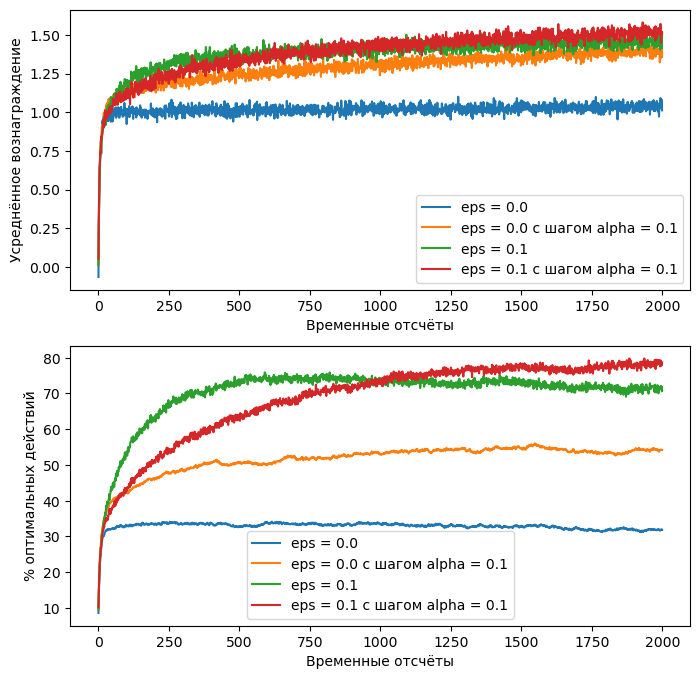

In [13]:
plt.figure(figsize=(8,8))     
plt.subplot(2, 1, 1)
for i, eps in enumerate(epsilons):
    plt.plot(all_rewards[2*i], label='eps = %.01f' % (eps))
    plt.plot(all_rewards[2*i+1], label='eps = %.01f с шагом alpha = 0.1' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
for i, eps in enumerate(epsilons):
    plt.plot(all_optimal[2*i], label='eps = %.01f' % (eps))
    plt.plot(all_optimal[2*i+1], label='eps = %.01f с шагом alpha = 0.1' % (eps))
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Как и ожидалость, формирование оценок ценностей с постоянным шагом обучения показывает более хороший результат в условиях, когда истинные ценности меняются.

### Демонстрация работы стратегий на основе ВДГ-действий

Продемонстрируем сравнение $\varepsilon$-жадной стратегии и стратегии, основанной на ВДГ-действии. Для этого добавим специальную функцию `get_action()` для выбора действия и добавим соответствующую строчку в основной код.


In [14]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_action(Q, N, epsilon, step, UCB=False, UCB_param=2):
    num_arms = len(Q)
    # выбор действия на основе ВДГ
    if UCB == True:
        UCB_estimation = Q + UCB_param * np.sqrt(np.log(step + 1) / (N + 1e-5))
        return np.argmax(UCB_estimation)
    # eps-жадный выбор действия
    if np.random.rand() < epsilon:
        return np.random.choice(num_arms)
    else:
        return np.argmax(Q)
        
def generate_Qtrue(num_arms=10):
    Q_true = np.random.randn(num_arms)
    return Q_true
    
def bandit_simulation(num_arms = 10, num_steps = 1000, num_episodes = 2000, epsilon = 0.01, 
                      initial=0.0, alpha = None, Q_changed = False, UCB = False):    
    # массив вознаграждений и массив с метками о выборе лучшего действия
    rewards = np.zeros((num_episodes, num_steps)) 
    best_action_counts = np.zeros((num_episodes, num_steps)) #
    
    for episode in tqdm(range(num_episodes)):
        # инициализация для запуска эпизода
        Q_true = generate_Qtrue(num_arms) 
        best_action = np.argmax(Q_true)
        Q = np.zeros(num_arms) + initial
        N = np.zeros(num_arms)
        # шаги эпизода
        for step in range(num_steps):
            # NEW: выбор действия
            action = get_action(Q, N, epsilon, step, UCB)    
                
            if action == best_action: 
                best_action_counts[episode, step] += 1

            # получение вознаграждения и обновление оценок
            reward = np.random.randn() + Q_true[action]
            if alpha is None:
                N[action] += 1
                Q[action] = Q[action] + (reward - Q[action])/N[action]
            else:
                Q[action] = Q[action] + alpha * (reward - Q[action])
            rewards[episode, step] = reward
            if Q_changed:
                Q_true +=  np.random.normal(0, 0.01, num_arms)
                best_action = np.argmax(Q_true)
    # усреднение
    avg_rewards = np.mean(rewards, axis = 0)
    avg_optimal = np.mean(best_action_counts, axis = 0)*100
        
    return avg_rewards, avg_optimal

Проведём симуляцию с тремя стратегиями:
1. $\varepsilon$-жадной стратегии с $\varepsilon = 0.05$;
2. $\varepsilon$-жадной стратегии с $\varepsilon = 0.1$;
3. Стратегия на основе ВДГ-действий.

In [15]:
all_rewards = []
all_optimal = []
avg_rewards, avg_optimal = bandit_simulation(epsilon=0.05)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(epsilon=0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(UCB = True)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)   

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.01it/s]


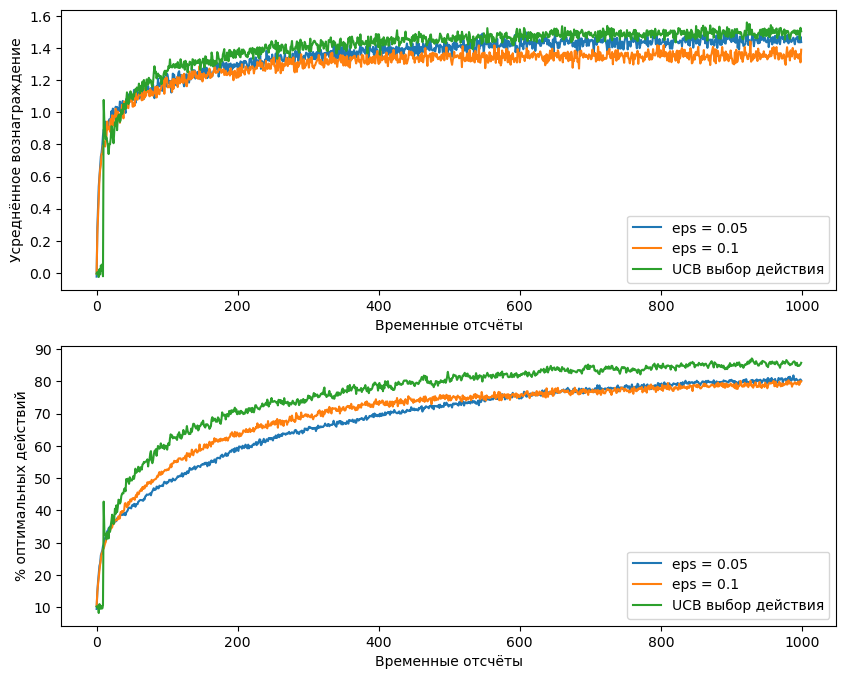

In [16]:
plt.figure(figsize=(10,8))  
plt.subplot(2, 1, 1)
plt.plot(all_rewards[0], label='eps = %.02f' % (0.05))
plt.plot(all_rewards[1], label='eps = %.01f' % (0.1))
plt.plot(all_rewards[2], label='UCB выбор действия')
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_optimal[0], label='eps = %.02f' % (0.05))
plt.plot(all_optimal[1], label='eps = %.01f' % (0.1))
plt.plot(all_optimal[2], label='UCB выбор действия')
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

В данном случае стратегия на основе ВДГ-действий показывает более лучший результат.

Рассмотрим также аналогичную симуляцию, когда истинные ценности со временем изменяются.

In [17]:
all_rewards = []
all_optimal = []
avg_rewards, avg_optimal = bandit_simulation(epsilon=0.05, Q_changed = True, alpha = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(epsilon=0.1, Q_changed = True, alpha = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(UCB = True, Q_changed = True, alpha = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)   

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.76it/s]


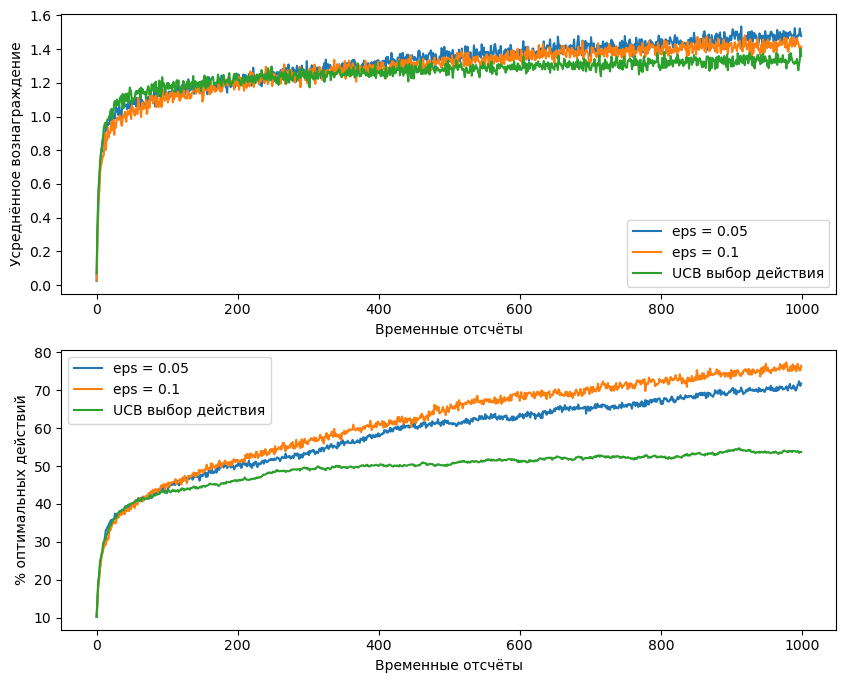

In [18]:
plt.figure(figsize=(10,8))     
plt.subplot(2, 1, 1)
plt.plot(all_rewards[0], label='eps = %.02f' % (0.05))
plt.plot(all_rewards[1], label='eps = %.01f' % (0.1))
plt.plot(all_rewards[2], label='UCB выбор действия')
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_optimal[0], label='eps = %.02f' % (0.05))
plt.plot(all_optimal[1], label='eps = %.01f' % (0.1))
plt.plot(all_optimal[2], label='UCB выбор действия')
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Как видно из симуляций, стратегия на основе ВДГ-действий показывает более худший результат при изменяющихся истинных ценностях.

### Демонстрация стратегии на основе выборки Томпсона

Сравним работу $\varepsilon$-жадной стратегии и стратегии на основе выборки Томпсона. Напомним, что стратегия на основе выборки Томпсона применяется в несколько изменённой постановке. 

Истинные ценности действий или рычагов - это теперь числа от 0 до 1. Вознаграждение за выбор того или иного рычага - это либо 0, либо 1, причём 1 возвращается с вероятностью, равной истинной ценности этого рычага.

### *ЗАДАЧА*: дописать симуляцию с выбором действий на основе выборки Томпсона `bandit_simulation_TS()`.


In [7]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_Qtrue(num_arms=10):
    Q_true = np.random.rand(num_arms)
    return Q_true

def bandit_simulation_TS(num_arms = 10, num_steps = 1000, num_episodes = 2000, Q_changed = False):    
    # массив вознаграждений и массив с метками о выборе лучшего действия
    rewards = np.zeros((num_episodes, num_steps)) 
    best_action_counts = np.zeros((num_episodes, num_steps)) #
    
    for episode in tqdm(range(num_episodes)):
        # инициализация для запуска эпизода
        Q_true = generate_Qtrue(num_arms) 
        best_action = np.argmax(Q_true)
        
        # массивы для хранения числа успехов и числа неудач
        ???
        
        # шаги эпизода
        for step in range(num_steps):                  
            # формирование выборки оценок истинных вероятностей для каждого рычага и 
            # возврат рычага с максимальной оценкой
            ???
            action = ???
            # получение вознаграждения и обновление числа успехов\неудач
            ???
            reward = ???

            if action == best_action: 
                best_action_counts[episode, step] += 1
            rewards[episode, step] = reward
            
            if Q_changed:
                Q_true +=  np.random.normal(0, 0.01, num_arms)
                Q_true = np.clip(Q_true, 0.0, 1.0)
                best_action = np.argmax(Q_true)
    # усреднение
    avg_rewards = np.mean(rewards, axis = 0)
    avg_optimal = np.mean(best_action_counts, axis = 0)*100
        
    return avg_rewards, avg_optimal

In [8]:
all_rewards = []
all_optimal = []
avg_rewards, avg_optimal = bandit_simulation_TS()
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(epsilon = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(UCB = True)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 88.42it/s]


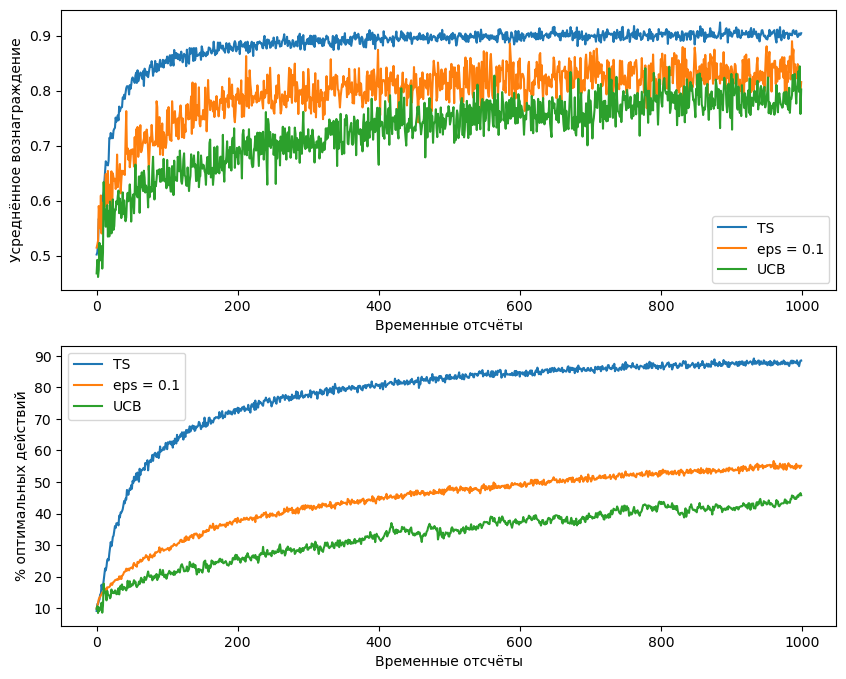

In [9]:
plt.figure(figsize=(10,8))     
plt.subplot(2, 1, 1)
plt.plot(all_rewards[0], label='TS')
plt.plot(all_rewards[1], label='eps = %.01f' % (0.1))
plt.plot(all_rewards[2], label='UCB')
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_optimal[0], label='TS')
plt.plot(all_optimal[1], label='eps = %.01f' % (0.1))
plt.plot(all_optimal[2], label='UCB')
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Из графиков можно отметить, что стратегия на основе выборки Томпсона проявила себя лучше всего.
Тот факт, что стратегия на основе ВДГ-действия показывает себя на 1000 шагах хуже, чем $\varepsilon$-жадная стратегия можно объяснить тем, что теперь дисперсия вектора истинных ценностей гораздо меньше и нужно накопить достаточно много статистики, чтобы доверительные интервалы позволяли устойчиво выявлять наилучший рычаг. 

Рассмотрим на симуляции также нестационарный случай.

In [24]:
all_rewards = []
all_optimal = []
avg_rewards, avg_optimal = bandit_simulation_TS(Q_changed = True)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(epsilon = 0.1, Q_changed = True, alpha = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)
avg_rewards, avg_optimal = bandit_simulation(UCB = True, Q_changed = True, alpha = 0.1)
all_rewards.append(avg_rewards)
all_optimal.append(avg_optimal)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.78it/s]


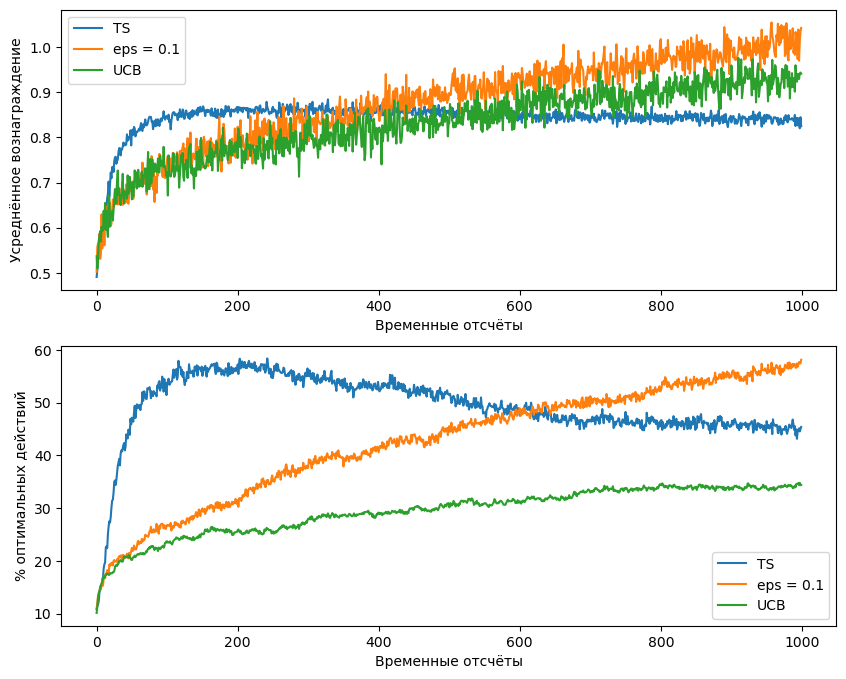

In [25]:
plt.figure(figsize=(10,8))     
plt.subplot(2, 1, 1)
plt.plot(all_rewards[0], label='TS')
plt.plot(all_rewards[1], label='eps = %.01f' % (0.1))
plt.plot(all_rewards[2], label='UCB')
plt.xlabel('Временные отсчёты')
plt.ylabel('Усреднённое вознаграждение')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(all_optimal[0], label='TS')
plt.plot(all_optimal[1], label='eps = %.01f' % (0.1))
plt.plot(all_optimal[2], label='UCB')
plt.xlabel('Временные отсчёты')
plt.ylabel('% оптимальных действий')
plt.legend()

Здесь $\varepsilon$-жадная стратегия с постоянным шагом обучения показала себя лучше всего. Стратегия на основе выборки Томпсона не позволяет достаточно быстро адаптироваться к изменениям истинных ценностей.

### *ЗАДАЧА*: дописать код и провести симуляцию с выбором действий на основе SoftMax-исследования.